# RNN Model Development

In [314]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from google.colab import drive 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [315]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [316]:
df=pd.read_csv('/content/gdrive/MyDrive/doge-hist-2y Kopie.csv')
df.rename(columns= {"Unnamed: 0": "Date"}, inplace= True)
df["Date"] = pd.to_datetime(df["Date"], infer_datetime_format= True)
df = df.set_index("Date")
df.interpolate(method= "linear", inplace= True)
print(df.shape)
df.head()

(732, 7)


,open,high,low,close,adjclose,volume,ticker
Date,,,,,,,
2019-11-23,0.002145,0.002275,0.002112,0.002273,0.002273,101846258.0,DOGE-EUR
2019-11-24,0.002276,0.002278,0.002085,0.002146,0.002146,92059493.0,DOGE-EUR
2019-11-25,0.002149,0.002151,0.001932,0.002076,0.002076,117692529.0,DOGE-EUR
2019-11-26,0.002077,0.002124,0.002054,0.002078,0.002078,90963851.0,DOGE-EUR
2019-11-27,0.002078,0.002143,0.002025,0.002126,0.002126,91194004.0,DOGE-EUR


In [317]:
df2 = pd.read_csv('/content/gdrive/MyDrive/doge_daily_google_trends_1y.csv')

df2["date"] = pd.to_datetime(df2["date"], infer_datetime_format= True)
df2 = df2.set_index("date")
df2.interpolate(method= "linear", inplace= True)
df2 = df2[["Dogecoin"]]

In [318]:
df2.head()

,Dogecoin
date,
2020-11-25,100
2020-11-26,39
2020-11-27,31
2020-11-28,31
2020-11-29,33


In [319]:
df2.shape

(309, 1)

In [320]:
df_final = df[["high"]].join(df2, how= "outer")

In [321]:
df_final.dropna(inplace= True)

In [322]:
df_final.rename(columns={"Dogecoin": "Google_Trends"}, inplace= True)

In [323]:
df_final.shape

(308, 2)

In [324]:
df_final

,high,Google_Trends
2020-11-25,0.003577,100.0
2020-11-26,0.003181,39.0
2020-11-27,0.002814,31.0
2020-11-28,0.002900,31.0
2020-11-29,0.002951,33.0
...,...,...
2021-11-19,0.209374,83.0
2021-11-20,0.209047,76.0
2021-11-21,0.206740,69.0
2021-11-22,0.201781,72.0


# Log-transformation

In [325]:
df_final["high"] = np.log(df_final["high"])

# Reshaping Data

In [326]:
## creating train_test_split and scaling values

# instantiating a scaler
scaler = MinMaxScaler()

# selecting relevant column from df
dataset = df_final.values

# splitting into train and test data
split = int(dataset.shape[0]*0.8)

train, test = dataset[:split], dataset[split:]

# scaling the data
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

history_size = 2

# creating arrays X, y for train and test data 
def get_X_y(history_size, dataset):

  X = []
  y = []

  for i in range(history_size, dataset.shape[0]):
    X.append(dataset[i-history_size:i,:])
    y.append(dataset[i,0])

  return np.array(X), np.array(y)


X_train, y_train = get_X_y(history_size, train)
X_test, y_test = get_X_y(history_size, test)

In [327]:
X_train[0], y_train[0]

(array([[0.06118267, 1.        ],
        [0.03972341, 0.39      ]]), 0.017302139761037116)

In [328]:
X_train.shape

(244, 2, 2)

In [329]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],2))

In [330]:
X_train.shape

(244, 2, 2)

In [331]:
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],2))

In [332]:
X_test.shape

(60, 2, 2)

# Modeling

In [249]:
# instantiating a model
model = Sequential()

# first network layer
model.add(LSTM(units = 50, return_sequences= True, input_shape = (X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

# network layer's 2 - 5
model.add(LSTM(units= 50, return_sequences= True))
model.add(Dropout(0.2))
#model.add(LSTM(units = 20, return_sequences= True))
#model.add(Dropout(0.2))
#model.add(LSTM(units= 50, return_sequences= True))
#model.add(Dropout(0.2))
#model.add(LSTM(units= 50, return_sequences= True))
#model.add(Dropout(0.2))
model.add(LSTM(units= 10, return_sequences= False))
model.add(Dropout(0.2))

# network output layer
model.add(Dense(units= 1))

model.compile(optimizer= "adam", loss= "mse")

In [250]:
model

In [226]:
es = EarlyStopping(patience = 50, restore_best_weights= True)

model.fit(X_train, 
          y_train,
          validation_split= 0.2,
          epochs = 1000,
          batch_size= 32,
          #callbacks= [es],
          verbose= 1)

Epoch 1/1000
7/7 [==============================] - 0s 21ms/step - loss: 0.0108 - val_loss: 0.0025
Epoch 2/1000
7/7 [==============================] - 0s 15ms/step - loss: 0.0123 - val_loss: 8.0414e-04
Epoch 3/1000
7/7 [==============================] - 0s 16ms/step - loss: 0.0088 - val_loss: 0.0034
Epoch 4/1000
7/7 [==============================] - 0s 16ms/step - loss: 0.0113 - val_loss: 7.1718e-04
Epoch 5/1000
7/7 [==============================] - 0s 17ms/step - loss: 0.0128 - val_loss: 2.9815e-04
Epoch 6/1000
7/7 [==============================] - 0s 15ms/step - loss: 0.0110 - val_loss: 0.0014
Epoch 7/1000
7/7 [==============================] - 0s 15ms/step - loss: 0.0114 - val_loss: 0.0012
Epoch 8/1000
7/7 [==============================] - 0s 15ms/step - loss: 0.0094 - val_loss: 6.4422e-04
Epoch 9/1000
7/7 [==============================] - 0s 15ms/step - loss: 0.0105 - val_loss: 3.1767e-04
Epoch 10/1000
7/7 [==============================] - 0s 16ms/step - loss: 0.0118 - val_lo

# Inverse Transform

In [227]:
def inverse_transformer(y):
  '''takes a one-dimensional input array (y_test or y_hat) and inverse transforms it.'''
  y = np.c_[y, np.ones(len(y))]
  y = scaler.inverse_transform(y)
  y= y[:,0]
  return y

In [228]:
real_stock_price = inverse_transformer(y_test)

predicted_stock_price = inverse_transformer(model.predict(X_test))

# Inverse Log Transform

In [229]:
real_stock_price = np.exp(real_stock_price)

predicted_stock_price = np.exp(predicted_stock_price)

# Evaluate

RMSE = 0.030922837123372217


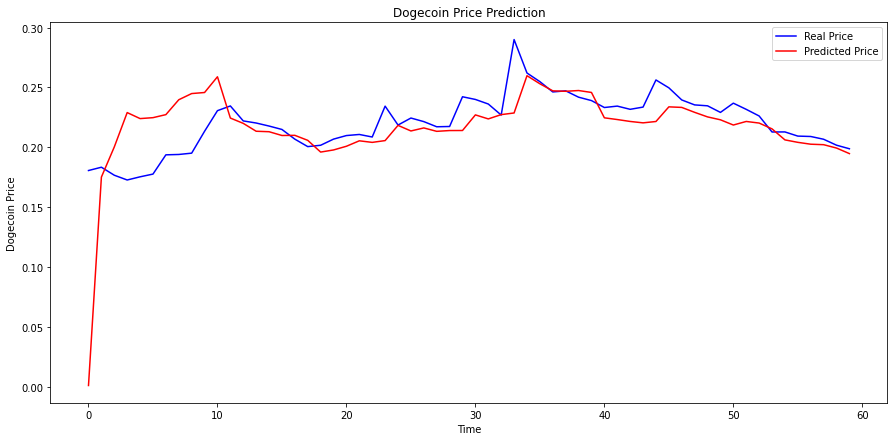

In [251]:
rmse = np.sqrt(mean_squared_error(real_stock_price, predicted_stock_price))

print(f"RMSE = {rmse}")

plt.figure(figsize= (15,7))
plt.plot(real_stock_price, color = 'blue', label = "Real Price")
plt.plot(predicted_stock_price, color = 'red', label = "Predicted Price")
plt.title("Dogecoin Price Prediction")
plt.xlabel("Time")
plt.ylabel("Dogecoin Price")
plt.legend()

plt.show()

# Notes on different model performances

In [252]:
eval_dict = {"optimizer": ["adam","adam","adam","adam","adam","adam","adam","adam","adam", "adam", "rmsprop", "rmsprop", "adam"],
             "loss": ["mse","mse","mse","mse","mse","mse","mse","mse","mse", "mse", "mse", "mse", "mse"],
              "history_size": [14, 14, 3, 3, 2, 1, 2, 2, 2, 2, 2, 2, 2],
             "epochs": [500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500],
             "layer0": [50,50,50,50,50,50, 50, 50, 50, 50, 50, 100, 100],
            "layer1": [10, 20, 20, 20, 50, 50, 0, 50, 20, 20, 50, 10, 10],
           "layer2": [10, 10, 10, 20, 10, 10, 0, 50, 0, 10, 10, 0, 0],
           "layer3": [0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0],
           "layer4": [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
           "layer5": [0, 0, 0, 0, 0, 0,0, 0, 0, 0, 0, 0, 0],
            "output": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
             "batch_size": [32,32,32,32,32,32,32,32,32,32,32,32,32],
           "rmse": [0.051, 0.037, 0.017, 0.018, 0.014, 0.021, 0.020, 0.023, np.NaN, 0.023, np.NaN, 0.020, 0.022]}

eval_df = pd.DataFrame.from_dict(eval_dict)

#for k,v in eval_dict.items():
  #print(f"{k} : {len(v)}")

eval_df

,optimizer,loss,history_size,epochs,layer0,layer1,layer2,layer3,layer4,layer5,output,batch_size,rmse
0,adam,mse,14,500,50,10,10,0,0,0,1,32,0.051
1,adam,mse,14,500,50,20,10,0,0,0,1,32,0.037
2,adam,mse,3,500,50,20,10,0,0,0,1,32,0.017
3,adam,mse,3,500,50,20,20,10,0,0,1,32,0.018
4,adam,mse,2,500,50,50,10,0,0,0,1,32,0.014
5,adam,mse,1,500,50,50,10,0,0,0,1,32,0.021
6,adam,mse,2,500,50,0,0,0,0,0,1,32,0.020
7,adam,mse,2,500,50,50,50,0,0,0,1,32,0.023
8,adam,mse,2,500,50,20,0,0,0,0,1,32,NaN
9,adam,mse,2,500,50,20,10,0,0,0,1,32,0.023


In [333]:
df_final.head()

,high,Google_Trends
2020-11-25,-5.633231,100.0
2020-11-26,-5.750560,39.0
2020-11-27,-5.873148,31.0
2020-11-28,-5.843045,31.0
2020-11-29,-5.825611,33.0


In [334]:
df_pred = pd.DataFrame(X_test[0], columns= ["high", "Google_trends"])
df_pred

,high,Google_trends
0,0.771134,0.89
1,0.775082,0.74


In [335]:
def preprocess(df, scaler):
    """method that pre-process the data"""

    # log transforming the data
    df["high"] = np.log(df["high"])

    # selecting relevant column from df
    dataset = df.values

    # scaling the data
    dataset_scaled = scaler.fit_transform(dataset)

    dataset_scaled = dataset_scaled.reshape(1,dataset.shape[0],dataset.shape[1])

    return dataset_scaled, scaler


def inverse_scaler(pred, scaler):

  pred = inverse_transformer(pred)

  pred = np.exp(pred)

  return pred

In [336]:
df_pred_preproc, scaler = preprocess(df_pred, scaler)

In [337]:
pred = model.predict(df_pred_preproc)
prediction = inverse_scaler(pred, scaler)[0][0]

prediction

array([0.77310893])

In [262]:
df_pred_preproc.shape

(1, 2, 2)

In [261]:
pred = model.predict(df_pred_preproc)[0][0]
pred

0.0017166738